***0. Install and Import Dependencies***

In [ ]:
!pip list

In [2]:
pip install opencv-python matplotlib imageio gdown tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [7]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


***1. Build Data Loading Functions***

In [8]:
import gdown

In [9]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=ae52d837-fbb4-4312-aa2c-61d8a4c8ecc2
To: C:\Users\SEC\data.zip
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 423M/423M [01:04<00:00, 6.55MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [10]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [11]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [12]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [13]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [14]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [15]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [16]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [17]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [18]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [19]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [20]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

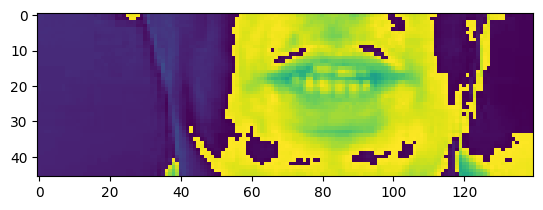

In [21]:
plt.imshow(frames[40])

In [22]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [23]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [24]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

***2. Create Data Pipeline***

In [25]:
from matplotlib import pyplot as plt

In [26]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [27]:
len(test)

50

In [28]:
frames, alignments = data.as_numpy_iterator().next()

In [29]:
len(frames)

2

In [30]:
sample = data.as_numpy_iterator()

In [31]:
val = sample.next(); val[0]

array([[[[[1.340357  ],
          [1.340357  ],
          [1.340357  ],
          ...,
          [0.31745297],
          [0.31745297],
          [0.3527255 ]],

         [[1.340357  ],
          [1.340357  ],
          [1.340357  ],
          ...,
          [0.38799807],
          [0.3527255 ],
          [0.24690786]],

         [[1.2345393 ],
          [1.2345393 ],
          [1.2345393 ],
          ...,
          [0.28218043],
          [0.24690786],
          [0.24690786]],

         ...,

         [[0.98763144],
          [0.98763144],
          [0.98763144],
          ...,
          [6.8076024 ],
          [7.9715967 ],
          [8.747593  ]],

         [[0.9523589 ],
          [0.9523589 ],
          [0.9523589 ],
          ...,
          [6.454877  ],
          [7.407236  ],
          [8.183232  ]],

         [[0.9523589 ],
          [0.9523589 ],
          [0.9523589 ],
          ...,
          [6.313787  ],
          [7.0545106 ],
          [7.7952337 ]]],


        [[[1.3403

In [34]:
print(uint8_frame.shape)  # Check the shape of the array


(75, 46, 140, 1)


In [35]:
import numpy as np
import imageio

# Assuming val[0][0] is your 4D array with shape (75, 46, 140, 1)
frames = val[0][0]  # Your data

# Remove the singleton dimension
frames = np.squeeze(frames)  # Now shape should be (75, 46, 140)

# Check the shape after squeezing
print(frames.shape)  # Should output (75, 46, 140)

# If frames are grayscale, you need to handle each frame individually
# Convert to an appropriate format for GIF
# Reshape to (75, 46, 140) -> (75, 140, 46) if necessary
frames = np.transpose(frames, (0, 2, 1))  # If required, swap height and width for image representation

# Scale values if needed (assuming values are in [0, 1])
frames = np.clip(frames, 0, 1)  # Ensure values are in [0, 1]
uint8_frames = (frames * 255).astype(np.uint8)  # Convert to uint8

# Save the GIF
imageio.mimsave('./animation.gif', uint8_frames, fps=10)  # Save as GIF


(75, 46, 140)


In [36]:
imageio.mimsave('./animation.gif', uint8_frames, fps=10)

In [37]:
print("Shape of the data:", val[0][0].shape)
print("Data type:", val[0][0].dtype)
print("Sample data:", val[0][0])


Shape of the data: (75, 46, 140, 1)
Data type: float32
Sample data: [[[[1.340357  ]
   [1.340357  ]
   [1.340357  ]
   ...
   [0.31745297]
   [0.31745297]
   [0.3527255 ]]

  [[1.340357  ]
   [1.340357  ]
   [1.340357  ]
   ...
   [0.38799807]
   [0.3527255 ]
   [0.24690786]]

  [[1.2345393 ]
   [1.2345393 ]
   [1.2345393 ]
   ...
   [0.28218043]
   [0.24690786]
   [0.24690786]]

  ...

  [[0.98763144]
   [0.98763144]
   [0.98763144]
   ...
   [6.8076024 ]
   [7.9715967 ]
   [8.747593  ]]

  [[0.9523589 ]
   [0.9523589 ]
   [0.9523589 ]
   ...
   [6.454877  ]
   [7.407236  ]
   [8.183232  ]]

  [[0.9523589 ]
   [0.9523589 ]
   [0.9523589 ]
   ...
   [6.313787  ]
   [7.0545106 ]
   [7.7952337 ]]]


 [[[1.340357  ]
   [1.340357  ]
   [1.340357  ]
   ...
   [0.28218043]
   [0.3527255 ]
   [0.3527255 ]]

  [[1.340357  ]
   [1.340357  ]
   [1.340357  ]
   ...
   [0.28218043]
   [0.24690786]
   [0.31745297]]

  [[1.2345393 ]
   [1.2345393 ]
   [1.2345393 ]
   ...
   [0.2116353 ]
   [0.211635

In [38]:
import numpy as np
import imageio

# Assuming val[0][0] is your 4D array with shape (75, 46, 140, 1)
frames = val[0][0]  # Your data

# Remove the singleton dimension (last dimension)
frames = np.squeeze(frames)  # Shape should now be (75, 46, 140)

# Check the shape after squeezing
print("Shape after squeezing:", frames.shape)  # Should output (75, 46, 140)

# Check the min and max values to scale them
print("Min value:", frames.min())
print("Max value:", frames.max())

# Scale the values to [0, 255] and convert to uint8
frames = np.clip(frames, 0, None)  # Clip to remove any negative values (if necessary)
frames = (frames / frames.max()) * 255  # Scale to [0, 255]
uint8_frames = frames.astype(np.uint8)  # Convert to uint8

# Check the shape and type of the uint8 frames
print("Shape of uint8 frames:", uint8_frames.shape)  # Should output (75, 46, 140)
print("Data type of uint8 frames:", uint8_frames.dtype)  # Should be uint8

# Save the GIF
imageio.mimsave('./animation.gif', uint8_frames, fps=10)  # Save as GIF

print("GIF animation created successfully.")


Shape after squeezing: (75, 46, 140)
Min value: 0.0
Max value: 8.994501
Shape of uint8 frames: (75, 46, 140)
Data type of uint8 frames: uint8
GIF animation created successfully.


In [39]:
import os

# After attempting to save the GIF, check the current directory
print("Current working directory:", os.getcwd())
print("Files in the directory:", os.listdir(os.getcwd()))


Current working directory: C:\Users\SEC
Files in the directory: ['.android', '.bash_history', '.cache', '.conda', '.condarc', '.config', '.continuum', '.emulator_console_auth_token', '.gitconfig', '.gradle', '.idlerc', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.m2', '.matplotlib', '.ms-ad', '.node_repl_history', '.ssh', '.stm32cubeide', '.stm32cubemx', '.stmcube', '.stmcufinder', '.VirtualBox', '.virtualenvs', '.vscode', '.zenmap', '1a client.py', '1a server.py', 'anaconda3', 'AndroidStudioProjects', 'animation.gif', 'AppData', 'Application Data', 'backgroundimage', 'c.txt', 'Circulate-the-values-of-N-variables', 'Circulate-the-values-of-N-variables-1', 'client.py', 'Contacts', 'Cookies', 'copy file.py', 'copy.py', 'data', 'data.zip', 'Debug', 'Desktop', 'Documents', 'Downloads', 'dPwdoBmbMGe', 'Favorites', 'file.txt', 'from http.py', 'get-pip.py', 'images', 'Links', 'lipnet.ipynb', 'Local Settings', 'logs', 'MathServer', 'Music', 'My Documents', 'NetHood', 'New folder',

In [40]:
import numpy as np
import imageio
import os

# Assuming val[0][0] is your 4D array with shape (75, 46, 140, 1)
frames = val[0][0]  # Your data

# Remove the singleton dimension (last dimension)
frames = np.squeeze(frames)  # Shape should now be (75, 46, 140)

# Check the shape after squeezing
print("Shape after squeezing:", frames.shape)  # Should output (75, 46, 140)

# Check the min and max values to scale them
print("Min value:", frames.min())
print("Max value:", frames.max())

# Scale the values to [0, 255] and convert to uint8
frames = np.clip(frames, 0, None)  # Clip to remove any negative values (if necessary)
frames = (frames / frames.max()) * 255  # Scale to [0, 255]
uint8_frames = frames.astype(np.uint8)  # Convert to uint8

# Check the shape and type of the uint8 frames
print("Shape of uint8 frames:", uint8_frames.shape)  # Should output (75, 46, 140)
print("Data type of uint8 frames:", uint8_frames.dtype)  # Should be uint8

# Ensure we have the correct orientation
# Transpose if necessary, (frames, height, width)
uint8_frames = np.transpose(uint8_frames, (0, 2, 1))  # Adjust to (frames, width, height) if necessary

# Save the GIF
gif_path = './animation.gif'
imageio.mimsave(gif_path, uint8_frames, fps=10)  # Save as GIF

print("GIF animation created successfully at:", gif_path)

# Check the current directory for the GIF file
print("Current working directory:", os.getcwd())
print("Files in the directory:", os.listdir(os.getcwd()))


Shape after squeezing: (75, 46, 140)
Min value: 0.0
Max value: 8.994501
Shape of uint8 frames: (75, 46, 140)
Data type of uint8 frames: uint8
GIF animation created successfully at: ./animation.gif
Current working directory: C:\Users\SEC
Files in the directory: ['.android', '.bash_history', '.cache', '.conda', '.condarc', '.config', '.continuum', '.emulator_console_auth_token', '.gitconfig', '.gradle', '.idlerc', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.m2', '.matplotlib', '.ms-ad', '.node_repl_history', '.ssh', '.stm32cubeide', '.stm32cubemx', '.stmcube', '.stmcufinder', '.VirtualBox', '.virtualenvs', '.vscode', '.zenmap', '1a client.py', '1a server.py', 'anaconda3', 'AndroidStudioProjects', 'animation.gif', 'AppData', 'Application Data', 'backgroundimage', 'c.txt', 'Circulate-the-values-of-N-variables', 'Circulate-the-values-of-N-variables-1', 'client.py', 'Contacts', 'Cookies', 'copy file.py', 'copy.py', 'data', 'data.zip', 'Debug', 'Desktop', 'Documents', 'Downloads

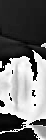

In [46]:
from IPython.display import Image, display

# Display the GIF
display(Image(filename='animation.gif'))  # Make sure the path is correct


In [52]:
from IPython.core.display import HTML

# Adjust width and let height adjust automatically
HTML('<img src="C:/Users/SEC/animation.gif" alt="Animation" style="width:100px;"/>')  # Change 100px to your desired width


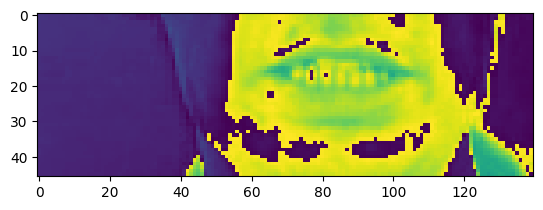

In [53]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

***3. Design the Deep Neural Network***

In [54]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [55]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [57]:
from keras.models import Sequential
from keras.layers import Conv3D, Activation, MaxPool3D, TimeDistributed, Flatten, Bidirectional, LSTM, Dropout, Dense, Input

# Define the model
model = Sequential()

# Use Input layer to define the input shape
model.add(Input(shape=(75, 46, 140, 1)))  # Specify input shape here

model.add(Conv3D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))

# Optionally compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)                    │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 75, 46, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_4 (Conv3D)                    │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 75, 23, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 75, 11, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 75, 256)             │       6,660,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
5*17*75

6375

In [59]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [60]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'666666666666666666666666666666666666666666666ffff6666ffffffffnffffffffff'>

In [61]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'666666666666666666666666666666666666666666666ffff6666ffffffffnffffffffff'>

In [62]:
model.input_shape

(None, 75, 46, 140, 1)

In [63]:
model.output_shape

(None, 75, 41)

***4. Setup Training Options and Train***

In [64]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [65]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [66]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [67]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [69]:
from keras.callbacks import ModelCheckpoint
import os

# Set the path to save the checkpoint
checkpoint_path = os.path.join('models', 'checkpoint.weights.h5')

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Updated filepath
    monitor='loss',
    save_weights_only=True,
    verbose=1  # Optional: set to 1 to get verbose output during training
)

# Now you can use `checkpoint_callback` when training your model


In [102]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('models', 'checkpoint_{epoch:02d}.weights.h5'),  # Add epoch number to filename
    monitor='loss',
    save_weights_only=True,
    save_best_only=False
)



In [ ]:
example_callback = ProduceExample(test)

***5. Make a Prediction***

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [109]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('models', 'checkpoint_{epoch:02d}.weights.h5'),  # Use .weights.h5
    monitor='loss',
    save_weights_only=True,
    save_best_only=False
)


In [111]:
import os

# List files in the 'models' directory
print(os.listdir('models'))


['checkpoint', 'checkpoint.data-00000-of-00001', 'checkpoint.index', '__MACOSX']


In [112]:
filepath=os.path.join('models', 'checkpoint_{epoch:02d}.weights.h5')


In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

In [ ]:
5. Make a Prediction

In [116]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=90ad52d0-e3f0-4dcb-bd9b-b4bea81eec4a
To: C:\Users\SEC\checkpoints.zip
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94.5M/94.5M [00:19<00:00, 4.86MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [ ]:
model.load_weights('models/checkpoint')

In [118]:
test_data = test.as_numpy_iterator()

In [119]:
sample = test_data.next()

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
OUTPUT=[<tf.Tensor shape=(), dtype=string, numpy=b'bin red at s nine again'>]